#### **This Notebook Evalutates the Optimal Approach without the PageRank Filter or Feature Selection.**

The parameters were found by Optuna, optimsing for Group 10-Fold F1-Score

Import Libraries

In [2]:
import sys
sys.path.append('..')  # Adds the parent directory to the path so Python can find the `Cleaning_and_Evaluation` package
from Cleaning_and_Evaluation import *
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GroupKFold, cross_validate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report

Read the spectral data

In [3]:
df = pd.read_csv("../data/exosomes.raw_spectrum_400-1800.csv")
#df = pd.read_csv("../../data/400-1800_with_raw_scaled_surface_pagerank.csv")

In [4]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,293,400.22778,1765.6628,201210-1,Normal
1,201210-1-00,294,400.91116,1774.7809,201210-1,Normal
2,201210-1-00,295,401.59454,1769.0302,201210-1,Normal
3,201210-1-00,296,402.27789,1756.4220,201210-1,Normal
4,201210-1-00,297,402.96127,1758.8690,201210-1,Normal
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia
6239201,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia
6239202,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia
6239203,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia


#### **Select the chosen cleaning parameters then run the functions**

In [5]:
lam = 10 ** 9
p = 0.046
window_size = 51
poly_order = 3

#### **Here is how the affect one spectra**

>Raw Spectra

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

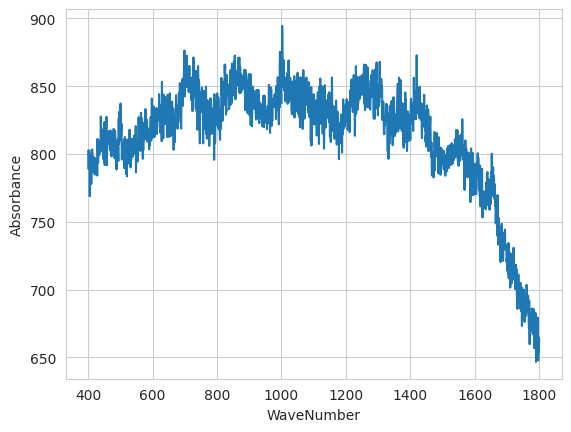

In [6]:
sample = df[df['SpecID'] == "201210-2-08"]
sns.set_style('whitegrid')
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

>Despiking

/tmp/ipykernel_23686/250951349.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x, ma=despike_ma, threshold=despike_threshold))


<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

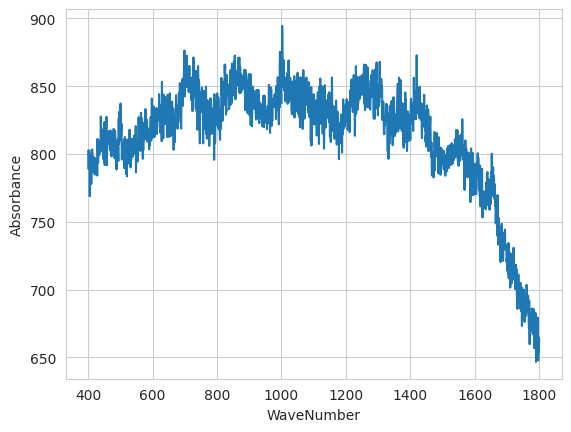

In [7]:
sample['Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x, ma=despike_ma, threshold=despike_threshold))
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

>Baseline Correction

/tmp/ipykernel_23686/2601916869.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))


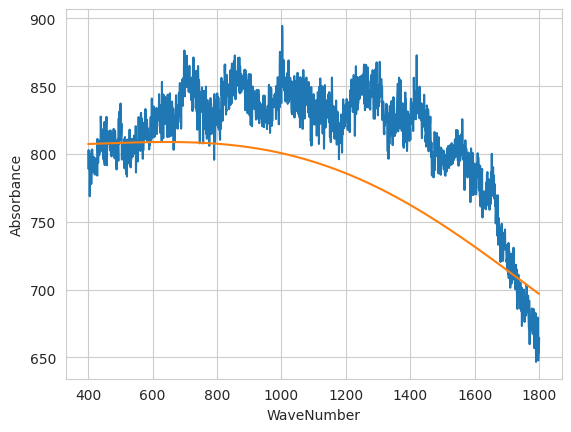

/tmp/ipykernel_23686/2601916869.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']


<Axes: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

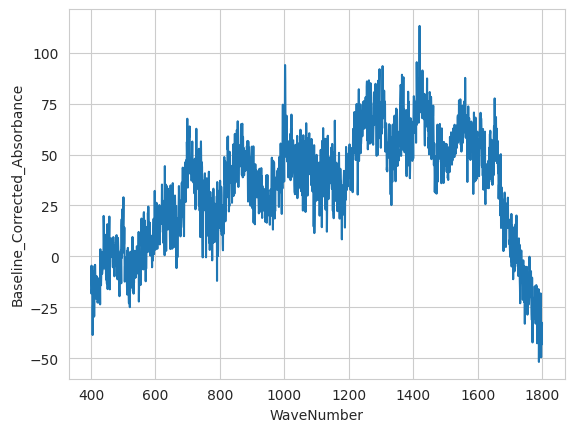

In [8]:
sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))
#sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: iasls_baseline_correction(x, lam=lam, p=p, lam_1=lam_1))

sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.lineplot(x="WaveNumber", y="Baseline", data=sample)
plt.show()

# Subtract the baseline
sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']
sns.lineplot(x="WaveNumber", y="Baseline_Corrected_Absorbance", data=sample)

>Vector Scaling

/tmp/ipykernel_23686/3447061085.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Scaled_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: vector_normalise(x))


<Axes: xlabel='WaveNumber', ylabel='Scaled_Absorbance'>

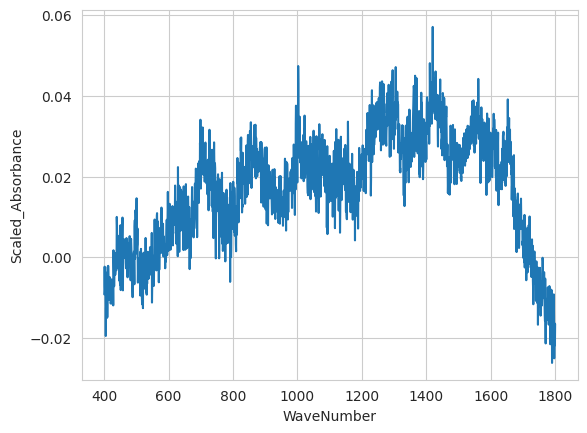

In [9]:
sample['Scaled_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: vector_normalise(x))
sns.lineplot(x="WaveNumber", y="Scaled_Absorbance", data=sample)

Repeat these steps for the full dataset.

In [10]:
df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x, ma=despike_ma, threshold=despike_threshold))

In [11]:
df['Baseline'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))
#df['Baseline'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: iasls_baseline_correction(x, lam=lam, p=p, lam_1=lam_1))

In [12]:
df['Absorbance'] = df['Absorbance'] - df['Baseline']

In [13]:
# df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [14]:
df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: vector_normalise(x))

In [15]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Baseline
0,201210-1-00,293,400.22778,0.004884,201210-1,Normal,1751.653961
1,201210-1-00,294,400.91116,0.008132,201210-1,Normal,1751.458071
2,201210-1-00,295,401.59454,0.006195,201210-1,Normal,1751.262182
3,201210-1-00,296,402.27789,0.001867,201210-1,Normal,1751.066293
4,201210-1-00,297,402.96127,0.002789,201210-1,Normal,1750.870403
...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,-0.013474,210526-3,Hyperglycemia,1702.398893
6239201,210526-3-09,2338,1797.72200,-0.010910,210526-3,Hyperglycemia,1701.920031
6239202,210526-3-09,2339,1798.40550,-0.010800,210526-3,Hyperglycemia,1701.441170
6239203,210526-3-09,2340,1799.08890,-0.009367,210526-3,Hyperglycemia,1700.962308


---

**Overall Performance**

In [16]:
svc = SVC(random_state=1234, kernel='rbf', C=4031032.988, gamma='scale')
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

evaluate_model(wavelength_df, svc)

/home/eddie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVC Cross-Validation Accuracy: 0.6123 +/- 0.0776
SVC Cross-Validation Precision: 0.6016 +/- 0.0846
SVC Cross-Validation Recall: 0.6168 +/- 0.1262
SVC Cross-Validation F1-Score: 0.5855 +/- 0.0987


---

**Evalutate By Class**

In [17]:
def evaluate_model_by_class(df, model):
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']
    
    # Get unique class names from the 'y' dataset
    class_names = y.unique()
    
    cv = GroupKFold(n_splits=10)

    accuracies = []
    precisions = [[] for _ in class_names]
    recalls = [[] for _ in class_names]
    f1_scores = [[] for _ in class_names]

    for train_idx, test_idx in cv.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracies.append(accuracy_score(y_test, y_pred))
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, zero_division=0, labels=class_names)
        for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
            precisions[i].append(p)
            recalls[i].append(r)
            f1_scores[i].append(f)

    print(f"{model.__class__.__name__} Cross-Validation Accuracy: {np.mean(accuracies):.4f} +/- {np.std(accuracies):.4f}\n")
    for i, class_name in enumerate(class_names):
        print(f"{class_name} Precision: {np.mean(precisions[i]):.4f} +/- {np.std(precisions[i]):.4f}")
        print(f"{class_name} Recall: {np.mean(recalls[i]):.4f} +/- {np.std(recalls[i]):.4f}")
        print(f"{class_name} F1-Score: {np.mean(f1_scores[i]):.4f} +/- {np.std(f1_scores[i]):.4f}\n")

In [19]:
evaluate_model_by_class(wavelength_df, svc)

SVC Cross-Validation Accuracy: 0.6123 +/- 0.0776

Normal Precision: 0.6159 +/- 0.2576
Normal Recall: 0.5596 +/- 0.2821
Normal F1-Score: 0.5640 +/- 0.2368

Hyperglycemia Precision: 0.5482 +/- 0.1479
Hyperglycemia Recall: 0.5668 +/- 0.1126
Hyperglycemia F1-Score: 0.5362 +/- 0.0912

Hypoglycemia Precision: 0.6406 +/- 0.1638
Hypoglycemia Recall: 0.7239 +/- 0.1519
Hypoglycemia F1-Score: 0.6563 +/- 0.1007



---

**Using Spectra Predictions to Predict the Surface**

In [20]:
def evaluate_and_predict_surface_status(df, model):
    
    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)
    
    # DataFrame to store the actual and predicted status for each spectrum
    predictions_df = pd.DataFrame(columns=['SurID', 'ActualStatus', 'PredictedStatus'])

    # Iterating over each fold
    for train_index, test_index in cv.split(X, y, groups=groups):
        # Splitting the dataset into the current train and test set
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        groups_test = groups.iloc[test_index]
        
        # Fitting the model on the training set
        model.fit(X_train, y_train)

        # Predicting the status for the test set
        y_pred = model.predict(X_test)

        # Appending the SurID, actual, and predicted status to the predictions DataFrame
        fold_predictions = pd.DataFrame({
            'SurID': groups_test.values,
            'ActualStatus': y_test.values,
            'PredictedStatus': y_pred
        })
        predictions_df = pd.concat([predictions_df, fold_predictions], ignore_index=True)

    # Return the most common prediction of each spectra within the surface
    return predictions_df.groupby('SurID').agg(lambda x: x.mode()[0]).reset_index()


In [21]:
surface_predictions = evaluate_and_predict_surface_status(wavelength_df, svn)
surface_predictions

NameError: name 'svn' is not defined

In [ ]:
print(classification_report(surface_predictions['ActualStatus'], surface_predictions['PredictedStatus']))

               precision    recall  f1-score   support

Hyperglycemia       0.65      0.68      0.67        19
 Hypoglycemia       0.78      0.82      0.80        22
       Normal       0.75      0.68      0.71        22

     accuracy                           0.73        63
    macro avg       0.73      0.73      0.73        63
 weighted avg       0.73      0.73      0.73        63

